In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorboard.plugins import projector
from sklearn.model_selection import train_test_split

from tensorflow.keras import backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
import csv
import os

C:\Users\2000w\anaconda3\envs\tf_2_5\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
# 파일 읽기
f = open("DIAMOND_I_battle_data.csv")
rdr = csv.reader(f)
r = list(rdr)
f.close()

label = []
sentences = []
for R in r[1:]:
    _sentences = ""
    _label = 0
    flag = 0
    for i, _R in enumerate(R):
        __R = _R.replace("[", "").replace("]", "").replace("'", "").replace(" ", "")
        if i > 0 and len(__R) > 1:
            __R = __R.split(",")
            if flag == 2:
                if "TFT6" in __R[0]:
                    flag = -1
                else:
                    flag = 0
            __R = "-".join(__R[:2]) + "#" + "#".join(sorted(__R[2:])) + " "
            _sentences += __R
        if i > 0 and len(__R) == 1:
            _label = float(__R)
            flag = 2
    if flag == 0:
        __sentences = _sentences.split(" ")
        for j, s in enumerate(__sentences):
            if "Augment" not in s:
                J = j
                break
        _sentences = " ".join(__sentences[:J]) + " ".join(sorted(__sentences[J:]))
        _sentences = _sentences.replace("#", " ")
        sentences.append(_sentences)
        label.append(_label)

# pandas dataframe
data = pd.DataFrame(zip(sentences, label), columns = ['sentence', 'label'])

# 토큰화
tokenizer = Tokenizer(filters = '', lower = False)
tokenizer.fit_on_texts(data['sentence'])
word_dic = tokenizer.word_index
word_count = tokenizer.word_counts

# 중복 제거
data = data.drop_duplicates(keep='first')

In [20]:
# 랜덤 데이터 생성: 무작위로 조합된 증강체와 기물을 데이터에 추가
random_data_num = 5000 # 랜덤 데이터 개수
random_data_label = 4.5 # 랜덤 데이터가 가지는 순위

augmentlist = []
champlist = []
itemlist = []

for w in word_dic:
    if (w == 'noItems') or ("TFT_Item" in w) or ("TFT3_Item" in w) or ("TFT4_Item" in w) or ("TFT5_Item" in w) or ("TFT6_Item" in w) or ("TFT7_Item" in w):
        itemlist.append(w)
    elif ("TFT_Augment" in w) or ("TFT3_Augment" in w) or ("TFT4_Augment" in w) or ("TFT5_Augment" in w) or ("TFT6_Augment" in w) or ("TFT7_Augment" in w):
        augmentlist.append(w)
    else:
        champlist.append(w)
        
random_data = []
for i in range(random_data_num):
    _random_data = ""
    for _ in range(3):
        _random_data += augmentlist[random.randint(0, len(augmentlist) - 1)] + " "
    for _ in range(random.randint(6, 9)):
        _random_data += champlist[random.randint(0, len(champlist) - 1)] + "#"
        _item = []
        for _ in range(3):
            if (R := random.randint(0, 100)) < 45:
                _item.append(itemlist[random.randint(1, len(itemlist) // 2 - 1)])
            elif R > 95:
                _item.append(itemlist[random.randint(len(itemlist) // 2, len(itemlist) - 1)])
            else:
                _item.append(itemlist[0])
        _item = sorted(_item)
        for item in _item:
            _random_data += item + "#"
        _random_data += " "
            
    __random_data = _random_data.split(" ")
    for j, s in enumerate(__random_data):
        if "Augment" not in s:
            J = j
            break
    _random_data = " ".join(__random_data[:J]) + " ".join(sorted(__random_data[J:]))
    _random_data = _random_data.replace("#", " ")

    random_data.append(_random_data)
    
random_label = [4.5 for _ in range(len(random_data))]
data = pd.DataFrame(zip(sentences + random_data, label + random_label), columns = ['sentence', 'label'])

In [23]:
# 학습, 테스트 데이터 스플릿
x_data, y_data = data['sentence'], data['label']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

# 학습, 테스트 데이터 토큰화, 패딩
sequences = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
x_train_encoded = pad_sequences(sequences, maxlen = 16, padding = 'post')
x_test_encoded = pad_sequences(sequences_test, maxlen = 16, padding = 'post')
vocab_size = len(word_dic) + 1

In [24]:
if not os.path.exists('/model'):
    os.makedirs('/model')

# 모델 구축
model = Sequential()
embedding = model.add(Embedding(vocab_size, 10, input_length = 16))
model.add(LSTM(32, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = RMSprop(learning_rate = 0.01))
history = model.fit(x_train_encoded, y_train, epochs=10, batch_size=20, validation_split=0.2)
model.save('model/my_model.h5')

Epoch 1/10
1356/1356 [==============================] - 11s 7ms/step - loss: 119.3347 - val_loss: 2.3806
Epoch 2/10
1356/1356 [==============================] - 10s 8ms/step - loss: 2.4271 - val_loss: 2.4251
Epoch 3/10
1356/1356 [==============================] - 10s 7ms/step - loss: 2.3581 - val_loss: 2.3688
Epoch 4/10
1356/1356 [==============================] - 10s 7ms/step - loss: 2.3047 - val_loss: 2.3575
Epoch 5/10
1356/1356 [==============================] - 10s 7ms/step - loss: 2.2824 - val_loss: 2.3060
Epoch 6/10
1356/1356 [==============================] - 10s 7ms/step - loss: 2.2528 - val_loss: 2.4566
Epoch 7/10
1356/1356 [==============================] - 10s 7ms/step - loss: 2.2744 - val_loss: 2.3082
Epoch 8/10
1356/1356 [==============================] - 10s 7ms/step - loss: 2.2275 - val_loss: 2.3515
Epoch 9/10
1356/1356 [==============================] - 10s 7ms/step - loss: 2.2101 - val_loss: 2.3299
Epoch 10/10
1356/1356 [==============================] - 10s 7ms/step -

In [25]:
# 모델 평가
model.evaluate(x_test_encoded, y_test)

# Test 데이터셋 예측
x = np.arange(100)
predict = model.predict(x_test_encoded)

plt.figure(figsize = (12, 6))
plt.plot(x, predict[:100])
plt.plot(x, y_test[:100])
plt.show()

265/265 [==============================] - 1s 3ms/step - loss: 2.4159


2.4159274101257324

265/265 [==============================] - 1s 2ms/step


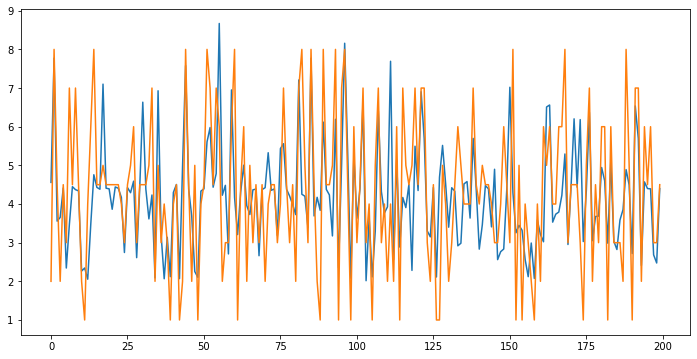

In [26]:
# 저장된 모델 불러오기
loaded_model = tf.keras.models.load_model('model/my_model.h5')
x = np.arange(200)
predict = loaded_model.predict(x_test_encoded)

plt.figure(figsize = (12, 6))
plt.plot(x, predict[:200])
plt.plot(x, y_test[:200])
plt.show()

In [29]:
# 텐서보드 config
# 새로운 데이터로 텐서보드를 실행하려면 현재 진행중인 텐서보드를 종료하고 텐서보드 temp 폴더 안의 log 데이터를 지운 뒤 실행하여야 한다.
# 텐서보드를 종료하려면 명령 프롬프트 창에서 taskkill /IM "tensorboard.exe" /F을 입력하면 된다.
# 텐서보드의 로그를 삭제하려면 %appdata% 폴더로 가서 Local/Temp/.tensorboardlogs에 있는 로그파일을 모두 지우면 된다.
log_dir = 'logs/imdb-example'


if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for subwords in word_dic:
        f.write("{}\n".format(subwords))


# Save the weights we want to analyze as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, here
# we will remove this value.
weights = tf.Variable(model.layers[0].get_weights()[0][1:])
# Create a checkpoint from embedding, the filename and key are the
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [31]:
# 텐서보드 실행
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

%reload_ext tensorboard

%tensorboard --logdir logs/imdb-example

Reusing TensorBoard on port 6006 (pid 20532), started 0:00:07 ago. (Use '!kill 20532' to kill it.)